In [3]:
#|default_exp resnet

In [4]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *

In [5]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
#|export
act_genrelu = partial(GeneralRelu, leak=0.1, sub=0.4)

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [9]:
def get_model(activation=nn.ReLU, channel_layers=None, norm=None):
    if channel_layers is None:
        channel_layers = [8,16,32,64,128]
    
    layers = [
        conv(1,8, stride=1, activation=activation, norm=norm)
        ] + [
        conv(channel_layers[i],
                   channel_layers[i+1],
                   activation=activation,
                   norm=norm
                  ) for i in range(len(channel_layers) - 1)] + [
        conv(channel_layers[-1], 10, activation=None, norm=False, bias=True),
        nn.Flatten()
    ]
    
    return nn.Sequential(*layers).to(def_device)


In [10]:
set_seed(42)
lr=6e-2
epochs=5
model=get_model(act_genrelu, norm=nn.BatchNorm2d).apply(iw)
max_steps =epochs * len( dls.train)
scheduler_partial = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=max_steps)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[BatchSchedCB(scheduler_partial)], opt_func=optim.AdamW)

In [11]:
#learn.fit(epochs)

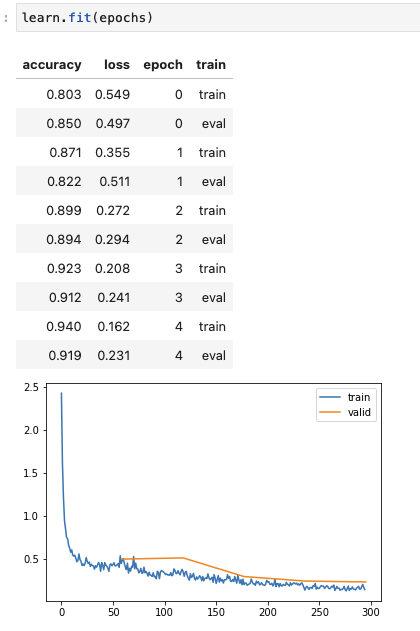

Multiple in and out channels. For a given output channel you'll have one kernal for each input, which are summed together to form the result (say, one pixel) of that output channel. So the parameters of the convolutional layer should essentially be (in_channels * out_channels * kernel_size * kernel_size)

In [12]:
mods = [mod for mod in learn.model.modules() if isinstance(mod, nn.Conv2d)]
mods

[Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Conv2d(128, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))]

In [13]:
[[p.shape for p in mods[i].parameters()] for i in range(len(mods))]

[[torch.Size([8, 1, 3, 3]), torch.Size([8])],
 [torch.Size([16, 8, 3, 3]), torch.Size([16])],
 [torch.Size([32, 16, 3, 3]), torch.Size([32])],
 [torch.Size([64, 32, 3, 3]), torch.Size([64])],
 [torch.Size([128, 64, 3, 3]), torch.Size([128])],
 [torch.Size([10, 128, 3, 3]), torch.Size([10])]]

... and sure enough that's what we get

In [14]:
#|export

'''
Note on convolution layers that change number of channels. Each output channel has a different
kernel corresponding to each of I input layers. The results of those I convolutions are combined
(for instance by adding, or averaging) to form the convolution result for that channel. Hence
the parameters shape for a conv layer with O output channels, I input channels, and K*K kernel is
(O, I, K, K).
'''

def _conv_block(in_channels, out_channels, stride, activation=act_genrelu, norm=None, ks=3):
    return nn.Sequential(
        # first conv in block: do NOT change image height/width (stride=1), DO change channel count.
        conv(in_channels, out_channels, kernel_size=ks, stride=1, activation=activation, norm=norm),
        # second cond: DO change image height/width (using stride), do NOT change channel count
        # (input and output channel count are the same)
        conv(out_channels, out_channels, kernel_size=ks, stride=stride, activation=None, norm=norm)
    )

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, ks=3, act=act_genrelu, norm=None):
        super().__init__()
        self.block = _conv_block(in_channels, out_channels, stride=stride, activation=act, norm=norm)
        
        '''
        The following two modules are relevent if either the number of channels, or the size of the
        image, respectively, are being changed. They're meant to try to preserve identity across such
        a dimensionality change. idconv applies a convolution layer to transform the channel count. 
        (Note to self, why can't we initialize the conv weights to something resembling an identity
        transformation from the getgo?). pool module can handle a stride which reduces image size
        because I don't think convolutions can increase image size, only upsampling does that. So
        pool in this case does an averaging over a number of pixels to match stride and downscales
        input appropriately.
        '''
        self.idconv = fc.noop if in_channels==out_channels else conv(in_channels, out_channels, stride=1, kernel_size=1, activation=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(stride, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        # conceptually, the pool is just part of the idconv, but it's broken out this way for simplicity
        return self.act(self.block(x) + self.idconv(self.pool(x)))

In [15]:
def get_resnet(act=nn.ReLU, channels=(8, 16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(channels[i], channels[i+1], act=act, norm=norm, stride=2) for i in range(len(channels)-1)]
    layers += [nn.Flatten(), nn.Linear(channels[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)


In [16]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_resnet()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1, do_train=False)

ResBlock torch.Size([1024, 1, 28, 28]) torch.Size([1024, 8, 28, 28])
ResBlock torch.Size([1024, 8, 28, 28]) torch.Size([1024, 16, 14, 14])
ResBlock torch.Size([1024, 16, 14, 14]) torch.Size([1024, 32, 7, 7])
ResBlock torch.Size([1024, 32, 7, 7]) torch.Size([1024, 64, 4, 4])
ResBlock torch.Size([1024, 64, 4, 4]) torch.Size([1024, 128, 2, 2])
ResBlock torch.Size([1024, 128, 2, 2]) torch.Size([1024, 256, 1, 1])
Flatten torch.Size([1024, 256, 1, 1]) torch.Size([1024, 256])
Linear torch.Size([1024, 256]) torch.Size([1024, 10])
BatchNorm1d torch.Size([1024, 10]) torch.Size([1024, 10])


In [17]:
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
    tot = 0
    def _f(hook, mod, inp, outp):
        nonlocal res,tot
        nparms = sum(o.numel() for o in mod.parameters())
        tot += nparms
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, do_train=False, cbs=SingleBatchCB())
    print("Tot params: ", tot)
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [18]:
TrainLearner(get_model(), dls, F.cross_entropy, cbs=DeviceCB()).summary()

Tot params:  109770


|Module|Input|Output|Num params|
|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 8, 28, 28)|80|
|Sequential|(1024, 8, 28, 28)|(1024, 16, 14, 14)|1168|
|Sequential|(1024, 16, 14, 14)|(1024, 32, 7, 7)|4640|
|Sequential|(1024, 32, 7, 7)|(1024, 64, 4, 4)|18496|
|Sequential|(1024, 64, 4, 4)|(1024, 128, 2, 2)|73856|
|Sequential|(1024, 128, 2, 2)|(1024, 10, 1, 1)|11530|
|Flatten|(1024, 10, 1, 1)|(1024, 10)|0|


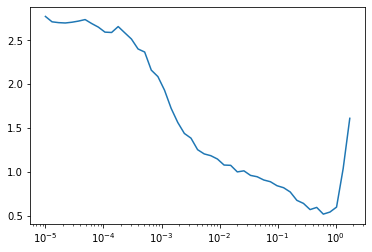

In [19]:
model=get_resnet(act_genrelu, norm=nn.BatchNorm2d).apply(iw)
MomentumLearner(model, dls, F.cross_entropy, cbs=DeviceCB()).lr_find()

In [20]:
epochs=5
lr=1e-1
max_steps = epochs*len(dls.train)
sched_partial=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=max_steps)
model=get_resnet(act_genrelu, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[BatchSchedCB(sched_partial)], opt_func=optim.AdamW)

In [21]:
#learn.fit(epochs)

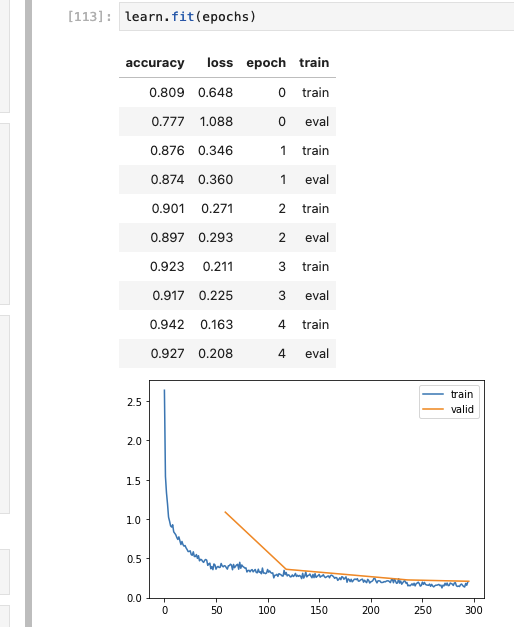

In [22]:
import timm
from timm.models.resnet import BasicBlock, ResNet, Bottleneck

In [23]:
' '.join(timm.list_models('*resnet*'))

'cspresnet50 cspresnet50d cspresnet50w eca_resnet33ts ecaresnet26t ecaresnet50d ecaresnet50d_pruned ecaresnet50t ecaresnet101d ecaresnet101d_pruned ecaresnet200d ecaresnet269d ecaresnetlight gcresnet33ts gcresnet50t inception_resnet_v2 lambda_resnet26rpt_256 lambda_resnet26t lambda_resnet50ts legacy_seresnet18 legacy_seresnet34 legacy_seresnet50 legacy_seresnet101 legacy_seresnet152 nf_ecaresnet26 nf_ecaresnet50 nf_ecaresnet101 nf_resnet26 nf_resnet50 nf_resnet101 nf_seresnet26 nf_seresnet50 nf_seresnet101 resnet10t resnet14t resnet18 resnet18d resnet26 resnet26d resnet26t resnet32ts resnet33ts resnet34 resnet34d resnet50 resnet50_gn resnet50c resnet50d resnet50s resnet50t resnet51q resnet61q resnet101 resnet101c resnet101d resnet101s resnet152 resnet152c resnet152d resnet152s resnet200 resnet200d resnetaa34d resnetaa50 resnetaa50d resnetaa101d resnetblur18 resnetblur50 resnetblur50d resnetblur101d resnetrs50 resnetrs101 resnetrs152 resnetrs200 resnetrs270 resnetrs350 resnetrs420 resne

accuracy,loss,epoch,train
0.820,0.506,0,train
0.802,1.011,0,eval
0.804,0.592,1,train
0.525,19.467,1,eval
0.857,0.387,2,train
0.864,0.380,2,eval
0.891,0.294,3,train
0.890,0.302,3,eval


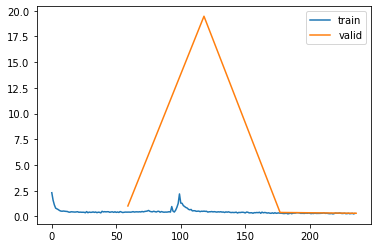

In [24]:
model = timm.create_model('cspresnet50', in_chans=1, num_classes=10)
lr = 2e-2
learner = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr,total_steps=(epochs * len(dls.train))))], opt_func=optim.AdamW)
learner.fit(4)

In [25]:
timm?

Type:        module
String form: <module 'timm' from '/usr/local/lib/python3.9/dist-packages/timm/__init__.py'>
File:        /usr/local/lib/python3.9/dist-packages/timm/__init__.py
Docstring:   <no docstring>


In [27]:
import nbdev; nbdev.nbdev_export()